Leandro Coelho <br>
BeeData<br>
Desafio Constelation <hr>
22/07/2023
<br>
Modelo geral
<br>
Objetivo:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error

from statsmodels.tsa.stattools import adfuller

pd.set_option('display.max_columns', 200)

In [2]:
holidays = pd.read_csv("https://raw.githubusercontent.com/LeandroCoelhos/BeeData/main/Desafio_Constellation/holidays_events.csv")
stores = pd.read_csv("https://raw.githubusercontent.com/LeandroCoelhos/BeeData/main/Desafio_Constellation/stores.csv")

d01 = pd.read_csv("https://raw.githubusercontent.com/LeandroCoelhos/BeeData/main/Desafio_Constellation/train_01.csv")
d02 = pd.read_csv("https://raw.githubusercontent.com/LeandroCoelhos/BeeData/main/Desafio_Constellation/train_02.csv")
d03 = pd.read_csv("https://raw.githubusercontent.com/LeandroCoelhos/BeeData/main/Desafio_Constellation/train_03.csv")
d04 = pd.read_csv("https://raw.githubusercontent.com/LeandroCoelhos/BeeData/main/Desafio_Constellation/train_04.csv")
d05 = pd.read_csv("https://raw.githubusercontent.com/LeandroCoelhos/BeeData/main/Desafio_Constellation/train_05.csv")
train = pd.concat([d01,d02,d03,d04,d05], axis=0)
train.id.value_counts()

0          1
2000584    1
2000586    1
2000587    1
2000588    1
          ..
1000298    1
1000299    1
1000300    1
1000301    1
3000887    1
Name: id, Length: 3000888, dtype: int64

In [3]:
del d01,d02, d03, d04, d05

# Transformar os tipos iniciais

In [4]:
def transformar_data(df,coluna):
  df[coluna] = pd.to_datetime(df[coluna])
  df[coluna] = df.date.dt.to_period('D')
  return df

def transformar_categoria(df, coluna):
  df[coluna] = df[coluna].astype('str').astype('category')
  return df

def preencher_calendario(df, coluna):
# Dicionário de mapeamento dos nomes dos dias da semana de inglês para português
  dias_da_semana_map = {
      'Monday': 'Segunda-feira',
      'Tuesday': 'Terça-feira',
      'Wednesday': 'Quarta-feira',
      'Thursday': 'Quinta-feira',
      'Friday': 'Sexta-feira',
      'Saturday': 'Sábado',
      'Sunday': 'Domingo'
  }
  df['dia_da_semana'] = df[coluna].dt.strftime('%A').map(dias_da_semana_map)
  df['ano'] = df[coluna].dt.year
  df['mes'] = df[coluna].dt.month
  df['dia'] = df[coluna].dt.day
  return df

In [5]:
# Treino
train = transformar_data(train, 'date')
train = transformar_categoria(train, 'family')
train = transformar_categoria(train, 'store_nbr')
train = preencher_calendario(train, 'date')

#Feriados
holidays = transformar_data(holidays, 'date')
holidays = transformar_categoria(holidays, 'type')

#lojas
stores = transformar_categoria(stores, 'type')
stores = transformar_categoria(stores, 'store_nbr')

# Incluir os tipos de lojas para filtrar

In [6]:
df = pd.merge(train, stores[['store_nbr','type']], how='left', left_on=['store_nbr'], right_on=['store_nbr'], suffixes=('_x', '_y'),  validate='many_to_one')
df.head()

,id,date,store_nbr,family,sales,onpromotion,dia_da_semana,ano,mes,dia,type
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Terça-feira,2013,1,1,D
1,1,2013-01-01,1,BABY CARE,0.0,0,Terça-feira,2013,1,1,D
2,2,2013-01-01,1,BEAUTY,0.0,0,Terça-feira,2013,1,1,D
3,3,2013-01-01,1,BEVERAGES,0.0,0,Terça-feira,2013,1,1,D
4,4,2013-01-01,1,BOOKS,0.0,0,Terça-feira,2013,1,1,D


In [7]:
# Quero só lojas do tipo A
#df_A = df[df.type == 'A']
df_A = df.copy()
df_A.type.value_counts()

D    1000296
C     833580
A     500148
B     444576
E     222288
Name: type, dtype: int64

<Axes: xlabel='date'>

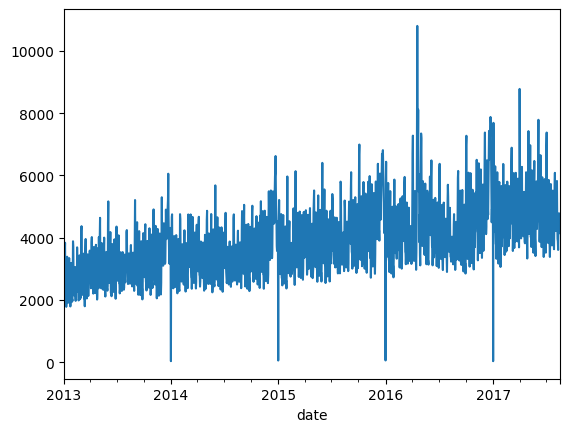

In [8]:
sales_by_family = df_A.groupby(['family', 'date']).sales.mean().unstack('family')
sales_by_family['GROCERY I'].plot()

In [9]:
results = {}
count = 0
for col in sales_by_family.columns:
    results[col] = adfuller(sales_by_family[col], regression='ctt')
    critical_values = results[col][4]
    p_value = results[col][1]
    t_stat = results[col][0]

    if critical_values['1%'] < t_stat:
        print(col,"|", f"T-Statistic: {t_stat:.3f}","|", f"Critical 1% value: {critical_values['1%']:.3f}","|",  f"P-Value: {p_value:.3f}")
        count += 1
f"{(1 - count/len(sales_by_family.columns)) * 100:.2f}% of the series are stationary at the 1% level"

BABY CARE | T-Statistic: -3.965 | Critical 1% value: -4.378 | P-Value: 0.035
BOOKS | T-Statistic: -3.494 | Critical 1% value: -4.378 | P-Value: 0.114
DAIRY | T-Statistic: -3.855 | Critical 1% value: -4.378 | P-Value: 0.047
EGGS | T-Statistic: -4.131 | Critical 1% value: -4.378 | P-Value: 0.021
LAWN AND GARDEN | T-Statistic: -3.714 | Critical 1% value: -4.378 | P-Value: 0.068
MAGAZINES | T-Statistic: -3.945 | Critical 1% value: -4.378 | P-Value: 0.037
POULTRY | T-Statistic: -3.452 | Critical 1% value: -4.378 | P-Value: 0.125
PREPARED FOODS | T-Statistic: -4.077 | Critical 1% value: -4.378 | P-Value: 0.025


'75.76% of the series are stationary at the 1% level'

In [10]:
sorted([x[1] for x in results.values()], reverse=True)[:5]

[0.12545865577810994,
 0.11448072568593598,
 0.06797483183359984,
 0.047091312757962314,
 0.036765396597287454]

In [11]:
# Identifying components of a time series
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf

average_sales = sales_by_family.mean(axis=1)
average_sales.index = average_sales.index.to_timestamp()
#seasonal_decompose(average_sales.iloc[-300:], period=7).plot();

In [12]:
#seasonal_decompose(average_sales.iloc[-300:], period=30).plot();

In [13]:
#seasonal_decompose(average_sales, period=365).plot();

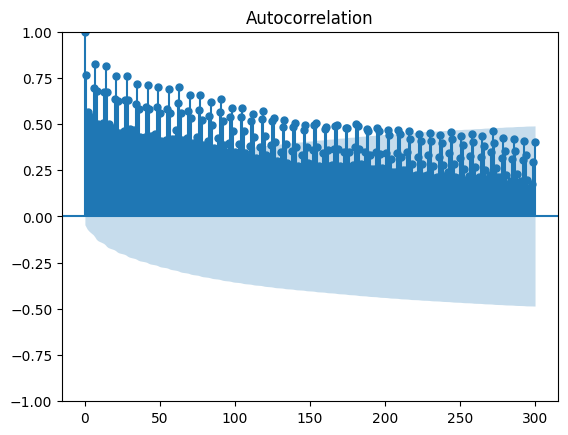

In [14]:
plot_acf(average_sales, lags=300);

In [15]:
# Constructing prediction series
y = df_A.set_index(['date', 'store_nbr', 'family']).sales.unstack(['store_nbr', 'family'])
X = pd.DataFrame(pd.Series(np.arange(len(y)) + 1,index=y.index), columns=['t'])
X.head()

,t
date,
2013-01-01,1
2013-01-02,2
2013-01-03,3
2013-01-04,4
2013-01-05,5


In [16]:
dev_limit = 1608
test_limit = 1608 + 30
test_fim = 1608 + 31 + 30

X_train = None
X_dev = None
X_test = None
X_dev_full = None

y_train = None
y_dev = None
y_test = None
y_dev_full = None

def redefine_Xy():
    global X_train, X_dev, X_test, y_train, y_dev, y_test, X_dev_full, y_dev_full

    X_train = X.iloc[:dev_limit]
    X_dev = X.iloc[dev_limit:test_limit]
    X_test = X.iloc[test_limit:test_fim]

    y_train = y.iloc[:dev_limit]
    y_dev = y.iloc[dev_limit:test_limit]
    y_test = y.iloc[test_limit:test_fim]

In [17]:
def fit_predict():
    model = LinearRegression(fit_intercept=False)
    model.fit(X_train, y_train)
    pred = pd.DataFrame(model.predict(X_dev), columns=y_dev.columns, index=y_dev.index)
    return pred

redefine_Xy()
pred = fit_predict()

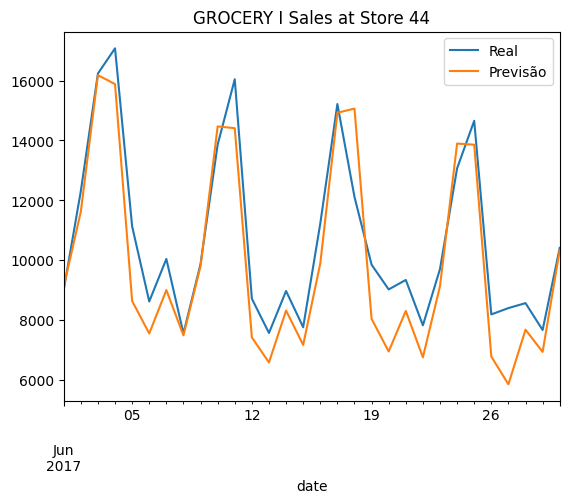

In [33]:
def plot(store_number, family):
    ax = y_dev[(store_number, family)].plot()
    ax = pred[(store_number, family)].plot(ax=ax)
    ax.set_title(f'{family} Sales at Store {store_number}')
    ax.legend(['Real', 'Previsão'])

plot('44', 'GROCERY I')

In [19]:
def mse(pred):
    return mean_squared_error(y_dev, pred, squared=False)
mse(pred)

229.21880260426894

# Adicionar Sazonalidade da Semana, do mês, e feriados

In [20]:
X['data'] = X.index
X = preencher_calendario(X, 'data')

In [21]:
X['ano_novo'] = (X.index.dayofyear == 1).astype(int)

In [22]:
X = pd.get_dummies(X, prefix=None, prefix_sep='_', dummy_na=False, columns=['dia_da_semana'], sparse=False, drop_first=False, dtype=None)

### Feriados

In [23]:
filtro = (holidays.locale_name == 'Ecuador') & ( holidays['type'].isin(['Bridge','Work Day','Additional','Holiday', 'Transfer', 'Event' ]) ) & (holidays.transferred == False)
feriados_considerados = holidays[filtro][['date', 'type']]
feriados_considerados = feriados_considerados.sort_values(by='type').drop_duplicates(subset='date')
feriados_considerados['feriado'] = 1
feriados_considerados.head()

,date,type,feriado
349,2017-12-26,Additional,1
87,2013-12-23,Additional,1
88,2013-12-24,Additional,1
293,2016-12-24,Additional,1
90,2013-12-26,Additional,1


In [24]:
X = pd.merge(X, feriados_considerados[['date', 'type']], how='left', left_on=['date'], right_on=['date'], suffixes=('_x', '_y'),  validate='one_to_one')
X = pd.get_dummies(X, prefix=None, prefix_sep='_', dummy_na=False, columns=['type'], sparse=False, drop_first=False, dtype=None)
X = X.set_index('date')
X

,t,data,ano,mes,dia,ano_novo,dia_da_semana_Domingo,dia_da_semana_Quarta-feira,dia_da_semana_Quinta-feira,dia_da_semana_Segunda-feira,dia_da_semana_Sexta-feira,dia_da_semana_Sábado,dia_da_semana_Terça-feira,type_Additional,type_Bridge,type_Event,type_Holiday,type_Transfer,type_Work Day
date,,,,,,,,,,,,,,,,,,,
2013-01-01,1,2013-01-01,2013,1,1,1,0,0,0,0,0,0,1,0,0,0,1,0,0
2013-01-02,2,2013-01-02,2013,1,2,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2013-01-03,3,2013-01-03,2013,1,3,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2013-01-04,4,2013-01-04,2013,1,4,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2013-01-05,5,2013-01-05,2013,1,5,0,0,0,0,0,0,1,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-08-11,1680,2017-08-11,2017,8,11,0,0,0,0,0,1,0,0,0,0,0,0,1,0
2017-08-12,1681,2017-08-12,2017,8,12,0,0,0,0,0,0,1,0,0,0,0,0,0,0
2017-08-13,1682,2017-08-13,2017,8,13,0,1,0,0,0,0,0,0,0,0,0,0,0,0


In [25]:
X['dezembro'] = np.where(X.mes == 12, 1 ,0 )

In [26]:
X = X.drop(columns=['data', 'ano', 'mes', 'dia']).fillna(0)
X

,t,ano_novo,dia_da_semana_Domingo,dia_da_semana_Quarta-feira,dia_da_semana_Quinta-feira,dia_da_semana_Segunda-feira,dia_da_semana_Sexta-feira,dia_da_semana_Sábado,dia_da_semana_Terça-feira,type_Additional,type_Bridge,type_Event,type_Holiday,type_Transfer,type_Work Day,dezembro
date,,,,,,,,,,,,,,,,
2013-01-01,1,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0
2013-01-02,2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2013-01-03,3,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2013-01-04,4,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2013-01-05,5,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-08-11,1680,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0
2017-08-12,1681,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2017-08-13,1682,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


# TRansformada de Furhier

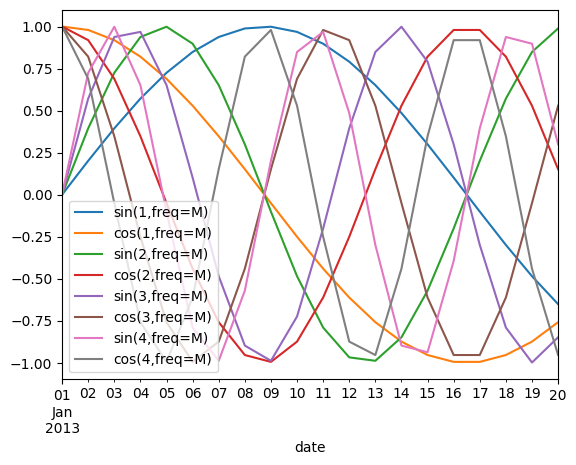

In [27]:
from statsmodels.tsa.deterministic import CalendarFourier

cal_fourier_gen = CalendarFourier("M", 4)
fourier = cal_fourier_gen.in_sample(y.index)
fourier.iloc[:20].plot();

In [28]:
X = pd.concat([X,fourier], axis=1)

#Avaliando

In [29]:
def redefine_limited_Xy():
    global X_train, X_dev, X_test, y_train, y_dev, y_test, X_dev_full, y_dev_full
    train_size = 150

    X_train = X.iloc[:dev_limit][-train_size:]
    X_dev = X.iloc[dev_limit:test_limit]
    X_test = X.iloc[test_limit:test_fim]

    y_train = y.iloc[:dev_limit][-train_size:]
    y_dev = y.iloc[dev_limit:test_limit]
    y_test = y.iloc[test_limit:test_fim]

89.92811308533167

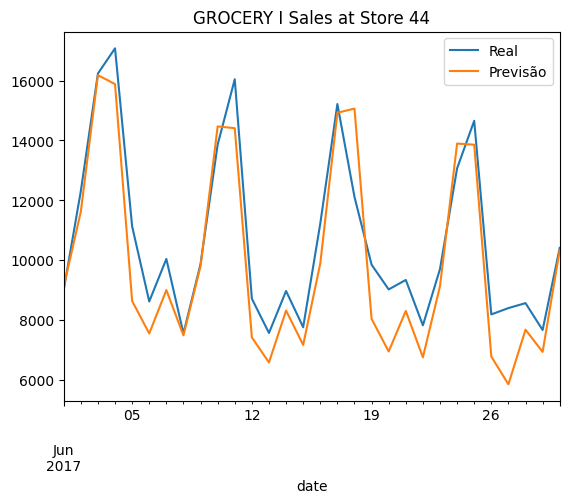

In [34]:
redefine_limited_Xy()
pred = fit_predict()
plot('44', 'GROCERY I')
mse(pred)

In [31]:
model = LinearRegression(fit_intercept=False)
model.fit(X_train, y_train)
pred = pd.DataFrame(model.predict(X_test), columns=y_test.columns, index=y_test.index)
mean_squared_error(y_test, pred, squared=False), y_test.mean().mean(), y_test.std().mean()

(97.99139361204428, 488.9663221069241, 141.6764133679994)